In [51]:
import pandas as pd
import numpy as np
import math,copy,os
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from pathlib import Path
from Measure import measure_final_score
import statistics
from CatEncoder import *
import glob
import pickle

In [52]:
def get_results(mut_op, selection, path_name):
    path = r'/Users/germainherbay/PycharmProjects/Blind/adult/score/blind/'+mut_op+'/'+selection+'/'+path_name+'/' # use your path
    all_files = glob.glob(path + "/*.csv")
    first_df = pd.read_csv(all_files[0])
    first_df['name'] = Path(all_files[0]).name
    first_df['operator'] = path_name
    first_df['mutation'] = mut_op+"_"+selection
    for filename in all_files[1:]:
        df = pd.read_csv(filename)
        df['name'] = Path(filename).name
        df['operator'] = path_name
        df['mutation'] = mut_op+"_"+selection
        first_df = first_df.append(df)
    first_df['model'] = first_df['model'].replace(['LogisticRegression()','RandomForestClassifier()', 'SVC()', 'MLPClassifier()'],['LR','RF','SVC', 'MLPC'])
    first_df.rename(columns = {'protected_att':'PA'}, inplace = True)
    return first_df

operators = ['age', 'capital-gain', 'capital-loss', 'education-num',
             'hours-per-week', 'marital-status', 'native-country', 'occupation',
             'race', 'relationship', 'sex', 'workclass']

def get_all_results(mut_op, operators, selection):
    df_1 = get_results(mut_op, selection, operators[0])
    for operator in operators[1:]:
        df = get_results(mut_op, selection, operator)
        df_1 = df_1.append(df)
    return df_1

df_cl_0_5 = get_all_results("change_label", operators, "0_5")
df_cl_1 = get_all_results("change_label", operators, "1")
df_cl_1_5 = get_all_results("change_label", operators, "1_5")
df_cl_2 = get_all_results("change_label", operators, "2")

df_sh_0_5 = get_all_results("shuffle", operators, "0_5")
df_sh_1 = get_all_results("shuffle", operators, "1")
df_sh_1_5 = get_all_results("shuffle", operators, "1_5")
df_sh_2 = get_all_results("shuffle", operators, "2")

df = df_cl_1.append(df_cl_0_5)
df = df_cl_1_5.append(df)
df = df_cl_2.append(df)
df = df_sh_0_5.append(df)
df = df_sh_1.append(df)
df = df_sh_1_5.append(df)
df = df_sh_2.append(df)


1.1 Analyse eod (sex) sentivity

[Text(0, 0, 'LR'), Text(1, 0, 'RF'), Text(2, 0, 'SVC'), Text(3, 0, 'MLPC')]

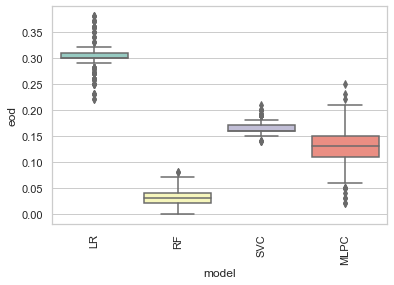

In [53]:
df_sex = df[df["PA"] == "sex"]
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="model", y="eod", data=df_sex, palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(),rotation = (90))

1.3 Analyse SPD (sex) sentivity

[Text(0, 0, 'LR'), Text(1, 0, 'RF'), Text(2, 0, 'SVC'), Text(3, 0, 'MLPC')]

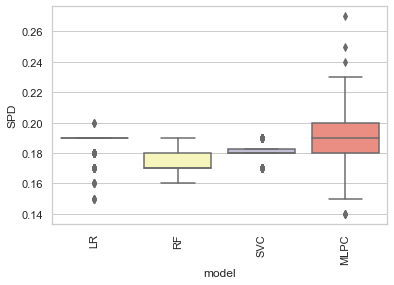

In [54]:
df_sex = df[df["PA"] == "sex"]
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="model", y="SPD", data=df_sex, palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(),rotation = (90))



Sensitivity scores

In [55]:
df_sens_sex = df_sex.groupby("model")["eod", "SPD"].agg([np.mean, np.min, np.max, np.std])
print(np.round(df_sens_sex, 3))

         eod                       SPD                   
        mean  amin  amax    std   mean  amin  amax    std
model                                                    
LR     0.304  0.22  0.38  0.023  0.186  0.15  0.20  0.008
MLPC   0.127  0.02  0.25  0.036  0.188  0.14  0.27  0.018
RF     0.033  0.00  0.08  0.013  0.174  0.16  0.19  0.005
SVC    0.165  0.14  0.21  0.011  0.182  0.17  0.19  0.005


/Users/germainherbay/Documents/GitHub/TIA/Interface/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


Min eod LR

In [56]:
a = df_sex[(df_sex["model"] == "LR") & (df_sex["eod"] == 0.22)]
print(a)



    PA model  recall  accuracy  precision   eod   SPD                name  \
0  sex    LR    0.38      0.81       0.71  0.22  0.15  education-num4.csv   
0  sex    LR    0.38      0.81       0.71  0.22  0.15  education-num2.csv   

        operator        mutation  
0  education-num  change_label_2  
0  education-num  change_label_2  


Min eod RF

In [57]:
a = df_sex[(df_sex["model"] == "RF") & (df_sex["eod"] == 0)]
print(a)


    PA model  recall  accuracy  precision  eod   SPD             name  \
1  sex    RF    0.60      0.83       0.69  0.0  0.17        race2.csv   
1  sex    RF    0.62      0.84       0.69  0.0  0.17  occupation1.csv   

     operator        mutation  
1        race  change_label_2  
1  occupation  change_label_1  


Min SPD RF

In [58]:
a = df_sex[(df_sex["model"] == "RF") & (df_sex["SPD"] == 0.16)]
print(a)


    PA model  recall  accuracy  precision   eod   SPD               name  \
1  sex    RF    0.61      0.84       0.69  0.02  0.16     workclass0.csv   
1  sex    RF    0.61      0.84       0.69  0.03  0.16    occupation3.csv   
1  sex    RF    0.57      0.82       0.67  0.02  0.16  capital-gain2.csv   
1  sex    RF    0.61      0.84       0.69  0.01  0.16           sex1.csv   

       operator        mutation  
1     workclass       shuffle_2  
1    occupation     shuffle_0_5  
1  capital-gain  change_label_2  
1           sex  change_label_1  


Min eod SVC

In [59]:
a = df_sex[(df_sex["model"] == "SVC") & (df_sex["eod"] == 0.14)]
print(a)

    PA model  recall  accuracy  precision   eod   SPD      name operator  \
2  sex   SVC    0.56      0.84       0.75  0.14  0.18  sex1.csv      sex   
2  sex   SVC    0.56      0.84       0.74  0.14  0.18  sex2.csv      sex   
2  sex   SVC    0.56      0.84       0.74  0.14  0.18  sex0.csv      sex   
2  sex   SVC    0.56      0.84       0.74  0.14  0.18  sex1.csv      sex   

           mutation  
2       shuffle_1_5  
2  change_label_1_5  
2    change_label_1  
2  change_label_0_5  


Min SPD SVC

In [60]:
a = df_sex[(df_sex["model"] == "SVC") & (df_sex["SPD"] == 0.17)]
print(a)


    PA model  recall  accuracy  precision   eod   SPD                name  \
2  sex   SVC    0.53      0.84       0.76  0.16  0.17  education-num4.csv   
2  sex   SVC    0.53      0.84       0.76  0.16  0.17  education-num2.csv   
2  sex   SVC    0.53      0.84       0.75  0.15  0.17  education-num2.csv   
2  sex   SVC    0.50      0.83       0.73  0.19  0.17   capital-gain0.csv   
2  sex   SVC    0.50      0.83       0.73  0.19  0.17   capital-gain1.csv   
2  sex   SVC    0.50      0.83       0.73  0.19  0.17   capital-gain3.csv   
2  sex   SVC    0.50      0.83       0.73  0.19  0.17   capital-gain2.csv   
2  sex   SVC    0.50      0.83       0.73  0.19  0.17   capital-gain4.csv   
2  sex   SVC    0.53      0.84       0.77  0.16  0.17   capital-loss3.csv   
2  sex   SVC    0.53      0.84       0.77  0.15  0.17   capital-loss2.csv   
2  sex   SVC    0.53      0.84       0.77  0.16  0.17   capital-loss0.csv   
2  sex   SVC    0.53      0.84       0.77  0.15  0.17   capital-loss1.csv   

Min eod MLPC

In [61]:
a = df_sex[(df_sex["model"] == "MLPC") & (df_sex["eod"] == 0.02)]
print(a)

    PA model  recall  accuracy  precision   eod   SPD                 name  \
3  sex  MLPC    0.55      0.84       0.75  0.02  0.14    capital-loss3.csv   
3  sex  MLPC    0.61      0.84       0.71  0.02  0.16  hours-per-week2.csv   

         operator        mutation  
3    capital-loss  change_label_2  
3  hours-per-week  change_label_1  


Min SPD MLPC

In [62]:
a = df_sex[(df_sex["model"] == "MLPC") & (df_sex["SPD"] == 0.14)]
print(a)

    PA model  recall  accuracy  precision   eod   SPD                name  \
3  sex  MLPC    0.55      0.84       0.75  0.02  0.14   capital-loss3.csv   
3  sex  MLPC    0.53      0.84       0.76  0.05  0.14  education-num1.csv   
3  sex  MLPC    0.53      0.84       0.75  0.08  0.14   capital-gain0.csv   
3  sex  MLPC    0.53      0.84       0.76  0.04  0.14   relationship4.csv   

        operator          mutation  
3   capital-loss    change_label_2  
3  education-num    change_label_2  
3   capital-gain  change_label_1_5  
3   relationship  change_label_1_5  


EOD analysis

In [63]:
import pandas as pd

data=[["LR","recall",-9],["LR","accuracy",-1],["LR","precision",0],["LR","EOD",-8],["LR","SPD",-4],
      ["RF","recall",-1],["RF","accuracy",-1],["RF","precision",0],["RF","EOD",-2],["RF","SPD",0],
      ["SVC","recall",0],["SVC","accuracy",0],["SVC","precision",-1],["SVC","EOD",-2],["SVC","SPD",0],
      ["MLPC","recall",-6],["MLPC","accuracy",0],["MLPC","precision",-3],["MLPC","EOD",-11],["MLPC","SPD",-5]
      ]
df = pd.DataFrame(data=data, columns=["model", "metric", "Impact of EOD improvement(%)"])

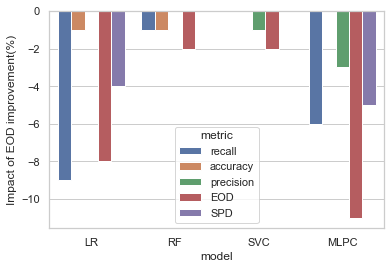

In [64]:
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.barplot(data=df, x="model", y="Impact of EOD improvement(%)", hue="metric")
ax.axhline(0, color='red', ls='-')

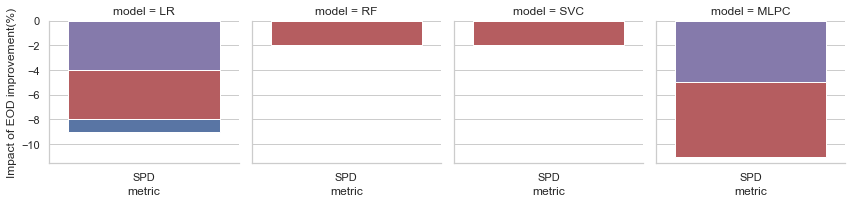

In [65]:
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.FacetGrid(df, col="model", hue="metric")
ax = ax.map_dataframe(sns.barplot, x="metric", y="Impact of EOD improvement(%)")


SPD analysis

In [66]:
import pandas as pd

data=[["LR","recall",-9],["LR","accuracy",-1],["LR","precision",0],["LR","EOD",-8],["LR","SPD",-4],
      ["RF","recall",0],["RF","accuracy",0],["RF","precision",0],["RF","EOD",0],["RF","SPD",-1],
      ["SVC","recall",-3],["SVC","accuracy",0],["SVC","precision",1],["SVC","EOD",0],["SVC","SPD",-1],
      ["MLPC","recall",-6],["MLPC","accuracy",0],["MLPC","precision",-3],["MLPC","EOD",-11],["MLPC","SPD",-5]
      ]
df = pd.DataFrame(data=data, columns=["model", "metric", "Impact of SPD improvement(%)"])

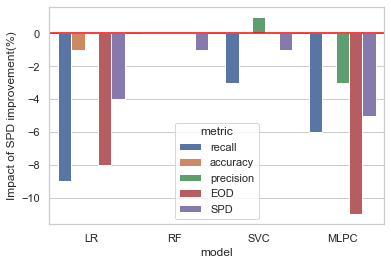

In [67]:
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.barplot(data=df, x="model", y="Impact of SPD improvement(%)", hue="metric")
ax.axhline(0, color='red', ls='-')